In [8]:
# Imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import numpy as np
import os
from src.utils.preprocess_utils import midi_to_note_indices, notes_to_one_hot
from src.utils.ml_utils import create_dataloaders, train_model, test_model, plot_metrics

In [9]:
# Define dataset
class MidiDataset(Dataset):
    def __init__(self, data_dir, sequence_length=50):
        self.data_dir = data_dir
        self.sequence_length = sequence_length
        self.file_names = [f for f in os.listdir(data_dir) if f.endswith('.mid') or f.endswith('.midi')]

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = os.path.join(self.data_dir, file_name)
        
        try:
            data = midi_to_note_indices(file_path)
            
            if len(data) < self.sequence_length:
                raise ValueError(f"File {file_name} is too short for sequence length {self.sequence_length}")
            
            # Pick a random starting index and crop the data to sequence_length
            start_idx = np.random.randint(0, len(data) - self.sequence_length + 1)
            cropped_data = data[start_idx:start_idx + self.sequence_length]

            x = cropped_data[:-1] # Input
            y = cropped_data[1:] # "Label"
            y = notes_to_one_hot(y, 0, 84)
            np.set_printoptions(threshold=np.inf)

            return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
        except Exception as e:
            print(f"Error processing {file_name}: {e}")
            # If the file is invalid or too short, retry with another random file
            new_idx = np.random.randint(0, len(self.file_names))
            return self.__getitem__(new_idx)

dataset_sequence_length = 50
dataset = MidiDataset(data_dir='data/midis', sequence_length=dataset_sequence_length)

In [10]:
# Get dataloaders with specified params from ml_utils
dataloader_train, dataloader_val, dataloader_test = create_dataloaders(dataset=dataset, batch_size=32, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, shuffle=True)

In [11]:
# Define model architecture
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, x, hidden=None):
        # x: [batch_size, sequence_length]
        x = x.long()
        embedded = self.embedding(x)  # [batch_size, sequence_length, embedding_size]
        lstm_out, hidden = self.lstm(embedded, hidden)  # [batch_size, sequence_length, hidden_size]
        output = self.fc(lstm_out)  # [batch_size, sequence_length, vocab_size]
        
        return output

vocab_size = 85 # Number of possible notes
embedding_size = 64 # Dimension of embedding vectors
hidden_size = 128 # Size of the hidden state
num_layers = 2 # Number of LSTM layers

model = LSTMModel(vocab_size, embedding_size, hidden_size, num_layers)


Error processing Gumpelzhaimer, Adam, Was mein Gott will, das g'scheh allzeit, BTQegBbW13A.mid: File Gumpelzhaimer, Adam, Was mein Gott will, das g'scheh allzeit, BTQegBbW13A.mid is too short for sequence length 50
Error processing Ferrari, Carlotta, D.E.A.TH., TVvpJ0ya_tQ.mid: File Ferrari, Carlotta, D.E.A.TH., TVvpJ0ya_tQ.mid is too short for sequence length 50
Error processing Menkveld, Jan Willem, Frech, Op.29 No.21, 4HhMyeQLCTw.mid: File Menkveld, Jan Willem, Frech, Op.29 No.21, 4HhMyeQLCTw.mid is too short for sequence length 50
Error processing Antico, Andrea, Per dolor mi bagno, uFY9NWLIpkc.mid: File Antico, Andrea, Per dolor mi bagno, uFY9NWLIpkc.mid is too short for sequence length 50
Error processing Berens, Hermann, 50 Piano Pieces for First Beginners, Op.70, 8I3SZtZHn2s.mid: File Berens, Hermann, 50 Piano Pieces for First Beginners, Op.70, 8I3SZtZHn2s.mid is too short for sequence length 50
Error processing Hill, Mildred, Good Morning Sweetheart, sbGiNDrZgR0.mid: File Hill

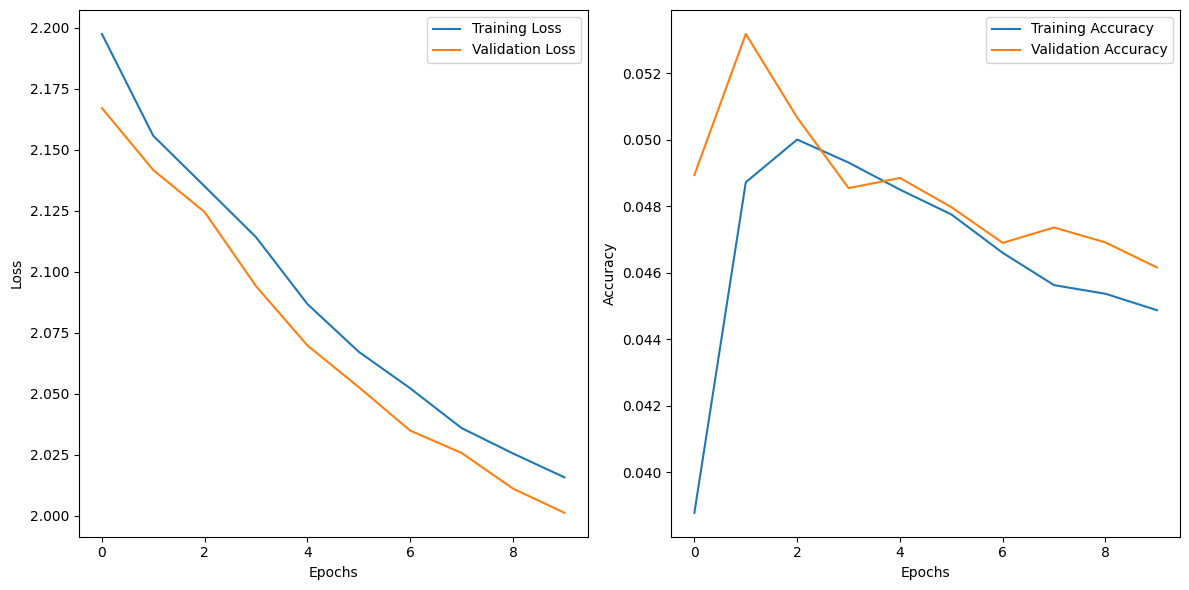

In [12]:
# Train model from ml_utils
best_model, history = train_model(
    model=model,
    dataloaders={"train": dataloader_train, "val": dataloader_val},
    task_type="multiclass",
    n_epochs=10,
    learning_rate=0.001,
    device="cuda"
)
(train_losses, val_losses, train_accuracy, val_accuracy) = history
plot_metrics(train_losses, val_losses, train_accuracy, val_accuracy)

In [13]:
# Test model from ml_utils
test_model(best_model, dataloader_test, nn.CrossEntropyLoss(), task_type="multiclass", device="cuda")

Test metrics - Loss: 2.0049, Accuracy: 0.0449


(np.float64(2.0049316111732933), np.float64(0.044857166050111544))

In [14]:
# Save model
from datetime import datetime

timestamp = datetime.today().strftime('%Y-%m-%d_%H-%M-%S')
filename = f'weights/model_2/{timestamp}_e{embedding_size}_h{hidden_size}_l{num_layers}_sl{dataset_sequence_length}'

torch.save(best_model, filename)